In [ ]:
"""
- Check channel count in a WAV file
- Downmix
- Upmix
- Channel mixer
"""

# Check channel count of a WAV file
from scipy.io.wavfile import read as wav_read, write as wav_write

def get_channel_count(file_path):
    """
    Get the channel count of a WAV file.
    :param file_path: Path to the WAV file
    :return: Number of channels
    """
    # Load the audio file
    sample_rate, audio = wav_read(file_path)
    
    # Check the shape of the audio data
    if len(audio.shape) > 1:
        return audio.shape[1]  # Stereo or multi-channel
    else:
        return 1  # Mono

# Example usage
music_file_path = "Data/CTHS3_Acid_Bass_Loop_01_C_123.wav"
music_channel_count = get_channel_count(music_file_path)
print(f"Channel Count: {music_channel_count}")

In [ ]:
# Downmix to mono if stereo
sample_rate, music_audio = wav_read(music_file_path)
if music_channel_count > 1:
    # Assuming the first channel is the left and the second is the right
    music_audio_mono = music_audio.mean(axis=1)
    print("Downmixed to mono.")
else:
    music_audio_mono = music_audio
    print("Already mono.")
# Save the downmixed audio if needed
wav_write("Output/downmixed_music_mono.wav", sample_rate, music_audio_mono.astype(music_audio.dtype))

In [ ]:
# Upmix to stereo using interleaved samples if mono
import numpy as np

sine_file_path = "Data/sine_wave_44100Hz_16bit_1min.wav"
sine_sample_rate, sine_audio = wav_read(sine_file_path)
sine_channel_count = get_channel_count(sine_file_path)

if sine_channel_count == 1:
    # Ensure the mono signal has an even number of samples for interleaving
    if len(sine_audio) % 2 != 0:
        sine_audio = sine_audio[:-1]  # Drop the last sample if odd

    # Interleave samples for stereo upmixing
    interleaved = np.empty((len(sine_audio) * 2,), dtype=sine_audio.dtype)
    interleaved[0::2] = sine_audio  # Left channel gets even indices
    interleaved[1::2] = sine_audio  # Right channel gets odd indices

    # Reshape into a stereo signal
    sine_audio_stereo = interleaved.reshape(-1, 2)
    print("Upmixed to stereo using interleaved samples.")
elif sine_channel_count > 2:
    # If more than 2 channels, just take the first two channels
    sine_audio_stereo = sine_audio[:, :2]
    print("More than 2 channels, taking the first two.")
else:
    sine_audio_stereo = sine_audio
    print("Already stereo.")

# Save the upmixed audio if needed
wav_write("Output/upmixed_sine_stereo_interleaved_fixed2.wav", sine_sample_rate, sine_audio_stereo.astype(sine_audio.dtype))

# Check the channel count of the upmixed audio
sine_channel_count_upmixed = get_channel_count("Output/upmixed_sine_stereo_interleaved_fixed2.wav")
print(f"Upmixed Channel Count: {sine_channel_count_upmixed}")

Input audio shape: (44100, 4)
Mix matrix shape: (4, 4)
Mixed audio shape: 44100 x 4
Mixed audio shape: (44100, 4)


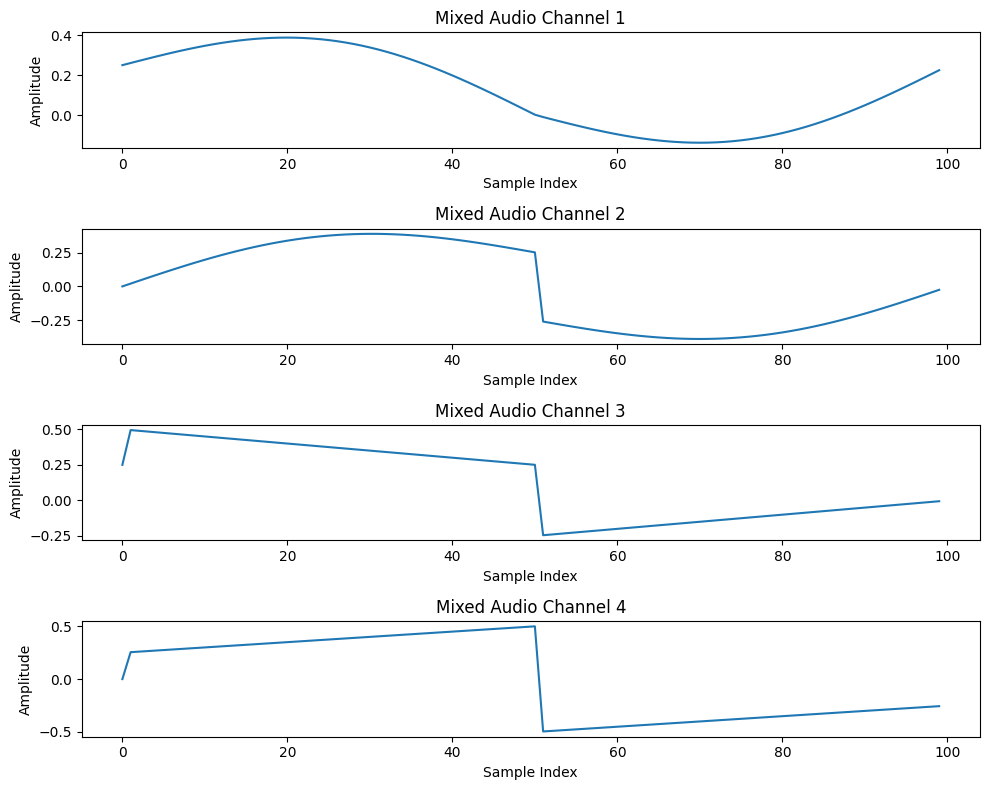

In [13]:
# A 4 by 4 channel mixer
import numpy as np
def channel_mixer(input_audio, mix_matrix):
    """
    Mix channels of the input audio using the provided mix matrix.
    :param input_audio: Input audio data
    :param mix_matrix: Mixing matrix
    :return: Mixed audio data
    """
    # Ensure the input audio is a 2D array
    if len(input_audio.shape) == 1:
        input_audio = input_audio[:, np.newaxis]
    
    # Perform the mixing
    mixed_audio = np.dot(input_audio, mix_matrix)
    
    return mixed_audio
# Example mixing matrix for 4 channels
mix_matrix = np.array([[0.5, 0.5, 0, 0],
                        [0, 0, 0.5, 0.5],
                        [0.5, 0, 0.5, 0],
                        [0, 0.5, 0, 0.5]])

# Generate a sine, square, triangle, and sawtooth wave as input audio
t = np.linspace(0, 1, 44100)
sine_wave = 0.5 * np.sin(2 * np.pi * 440 * t)  # Sine wave
square_wave = 0.5 * np.sign(np.sin(2 * np.pi * 440 * t))  # Square wave 
triangle_wave = 0.5 * (1 - np.abs(2 * (t * 440 - np.floor(t * 440 + 0.5))))  # Triangle wave
sawtooth_wave = 0.5 * (2 * (t * 440 - np.floor(t * 440 + 0.5)))  # Sawtooth wave
# Stack the waves to create a 4-channel input audio
input_audio = np.column_stack((sine_wave, square_wave, triangle_wave, sawtooth_wave))

# Ensure the input audio has the same number of channels as the mix matrix
if input_audio.shape[1] != mix_matrix.shape[0]:
    raise ValueError("Input audio channel count does not match mix matrix channel count.")
# Print the shape of the input audio
print("Input audio shape:", input_audio.shape)
# Print the shape of the mix matrix
print("Mix matrix shape:", mix_matrix.shape)
# Print the shape of the mixed audio
print("Mixed audio shape:", input_audio.shape[0], "x", mix_matrix.shape[1])

# Mix the audio
mixed_audio = channel_mixer(input_audio, mix_matrix)
print("Mixed audio shape:", mixed_audio.shape)

# Plot the 100 samples of the mixed audio in 4 plots
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
for i in range(mixed_audio.shape[1]):
    plt.subplot(4, 1, i + 1)
    plt.plot(mixed_audio[:100, i])
    plt.title(f"Mixed Audio Channel {i + 1}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


# The channel mixer takes an input audio signal and a mixing matrix, and applies the matrix to the audio signal.
# The mixing matrix defines how the input channels are combined to produce the output channels.
# The output channels are a linear combination of the input channels, weighted by the values in the mixing matrix.